# Swizterland Points of Interest -- Voronoi map

In [1]:
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [2]:
from shapely.ops import cascaded_union

In [3]:
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# read the points file

In [4]:
points = gpd.read_file("../data/switzerland-points-shape/points.shp")
points.head()

,osm_id,name,type,geometry
0,280587,Figuiers,bus_stop,POINT (6.61205 46.51706)
1,280590,Mont d'Or,bus_stop,POINT (6.61513 46.51689)
2,280615,None,traffic_signals,POINT (6.62316 46.52120)
3,280657,None,traffic_signals,POINT (6.62717 46.52703)
4,280690,None,mini_roundabout,POINT (6.68962 46.50159)


In [5]:
points['type']

0               bus_stop
1               bus_stop
2        traffic_signals
3        traffic_signals
4        mini_roundabout
              ...       
32359           crossing
32360        information
32361        information
32362               fuel
32363              hotel
Name: type, Length: 32364, dtype: object

In [6]:
n = 0
for i in points.index: 
        if points['type'][i] != "camp_site":
            points=points.drop(i)

In [70]:
points

,osm_id,name,type,geometry
499,26859456,Clenga,camp_site,POINT (10.45305 46.62889)
500,26859529,Generoso,camp_site,POINT (8.97667 45.92861)
501,26859686,Parco Sole,camp_site,POINT (8.95028 45.88861)
502,26859694,Piazale,camp_site,POINT (8.96917 45.93444)
503,26860558,AAregg,camp_site,POINT (8.04917 46.74778)
...,...,...,...,...
30737,427929406,Seepark Schiffenen,camp_site,POINT (7.19116 46.87979)
31516,430911565,Chez Alex,camp_site,POINT (6.87787 46.98373)
31599,431331766,Camping Rinerlodge,camp_site,POINT (9.77917 46.74544)
31601,431341284,Campingplatz FÃ¤rich,camp_site,POINT (9.85542 46.81077)


# read the swiss boundary

In [7]:
boundary = gpd.read_file("../data/switzerland-boundaries-shape/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp")
boundary.head()

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,OBJEKTART,REVISION_Q,ICC,KANTONSNUM,SEE_FLAECH,KANTONSFLA,KT_TEIL,NAME,EINWOHNERZ,geometry
0,{0B2364ED-49E0-4D53-A33C-C684DD530B57},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,18,NaN,710530.0,0,GraubÃ¼nden,198379.0,"POLYGON Z ((709776.070 185645.951 3063.268, 70..."
1,{DDD56CEF-0E61-4EED-85ED-F67A459C93ED},2019-11-06,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2019,...,Kanton,2019_Aufbau,CH,2,11897.0,595951.0,1,Bern,1034977.0,"POLYGON Z ((646448.480 181951.451 2349.027, 64..."
2,{54B25E50-30A7-4995-ADE3-5FFF6E13A995},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,23,1060.0,522463.0,0,Valais,343955.0,"POLYGON Z ((672688.370 144974.021 2926.027, 67..."
3,{921DFEF2-6D91-4CB8-9CFC-2A831C412020},2019-11-06,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2019,...,Kanton,2019_Aufbau,CH,22,39097.0,321202.0,1,Vaud,799145.0,"POLYGON Z ((571641.020 116683.450 2929.729, 57..."
4,{95F10F52-8B2F-4D6A-AF7E-D4F915E42F89},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,21,7147.0,281216.0,0,Ticino,353343.0,"POLYGON Z ((672688.370 144974.021 2926.027, 67..."


## check coordinate reference systems

In [9]:
boundary.crs = {'init': 'epsg:21781', 'no_defs': True}

In [10]:
boundary = boundary.to_crs({'init': 'epsg:4326'})

In [11]:
boundary.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Plot to check if they overlap well

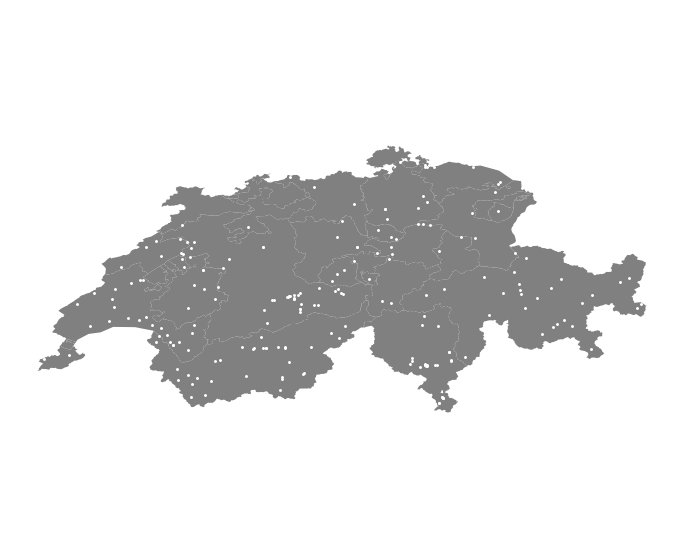

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color="gray")
points.plot(ax=ax, markersize=3.5, color="white")
ax.axis("off")
plt.axis("equal")
plt.show()

## Sample points

In [37]:
# points_sample = points.sample(n=500, random_state=7)
# len(points_sample)

500

In [14]:
boundary = boundary.to_crs(epsg=3395)
gdf_proj = points.to_crs(boundary.crs)

In [15]:
boundary.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - between 80°S and 84°N
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Combine Shapes

In [16]:
boundary_shape = cascaded_union(boundary.geometry)
coords = points_to_coords(gdf_proj.geometry)

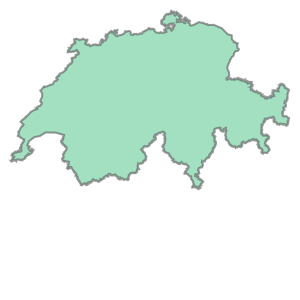

In [17]:
boundary_shape

In [18]:
boundary

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,OBJEKTART,REVISION_Q,ICC,KANTONSNUM,SEE_FLAECH,KANTONSFLA,KT_TEIL,NAME,EINWOHNERZ,geometry
0,{0B2364ED-49E0-4D53-A33C-C684DD530B57},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,18,NaN,710530.0,0,GraubÃ¼nden,198379.0,"POLYGON Z ((988188.289 5880422.022 3063.268, 9..."
1,{DDD56CEF-0E61-4EED-85ED-F67A459C93ED},2019-11-06,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2019,...,Kanton,2019_Aufbau,CH,2,11897.0,595951.0,1,Bern,1034977.0,"POLYGON Z ((895780.914 5876239.216 2349.027, 8..."
2,{54B25E50-30A7-4995-ADE3-5FFF6E13A995},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,23,1060.0,522463.0,0,Valais,343955.0,"POLYGON Z ((933382.363 5822123.420 2926.027, 9..."
3,{921DFEF2-6D91-4CB8-9CFC-2A831C412020},2019-11-06,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2019,...,Kanton,2019_Aufbau,CH,22,39097.0,321202.0,1,Vaud,799145.0,"POLYGON Z ((787167.990 5781765.711 2929.729, 7..."
4,{95F10F52-8B2F-4D6A-AF7E-D4F915E42F89},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,21,7147.0,281216.0,0,Ticino,353343.0,"POLYGON Z ((933382.363 5822123.420 2926.027, 9..."
5,{05D55405-466B-4ECC-83C7-A906DEB0D607},2017-12-04,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2018,...,Kanton,2019_Aufbau,CH,17,7720.0,202820.0,1,St. Gallen,507697.0,"POLYGON Z ((1060955.625 5954949.561 427.413, 1..."
6,{FB7105B8-6D7C-4787-846E-17B2BC145C6E},2018-11-22,2012-10-26,2012,10,2020,1,Verbessert,AV,2019,...,Kanton,2019_Aufbau,CH,1,6811.0,172894.0,0,ZÃ¼rich,1520968.0,"POLYGON Z ((965075.287 6022973.368 390.857, 96..."
7,{B01E1FB4-9A9B-48AC-BCA3-7D6D93BA23F3},2015-12-09,2012-10-26,2012,10,2020,1,Verbessert,AV,2015,...,Kanton,2019_Aufbau,CH,10,7818.0,167142.0,1,Fribourg,318714.0,"POLYGON Z ((789350.936 5895173.596 453.925, 78..."
8,{A7C284E4-45C4-44E2-ABAF-D1A0EAB10397},2019-11-06,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2019,...,Kanton,2019_Aufbau,CH,3,6438.0,149352.0,0,Luzern,409557.0,"POLYGON Z ((945441.376 5927126.102 413.630, 94..."
9,{E11CD2CA-2E2D-415C-8789-C10D7C26E441},2016-12-09,2012-10-26,2012,10,2020,1,Verbessert,swisstopo,2017,...,Kanton,2019_Aufbau,CH,19,870.0,140380.0,1,Aargau,678207.0,"POLYGON Z ((885750.808 5985199.638 521.379, 88..."


# Plot Voronoi

In [19]:
# Calculate Voronoi Regions
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, boundary_shape)

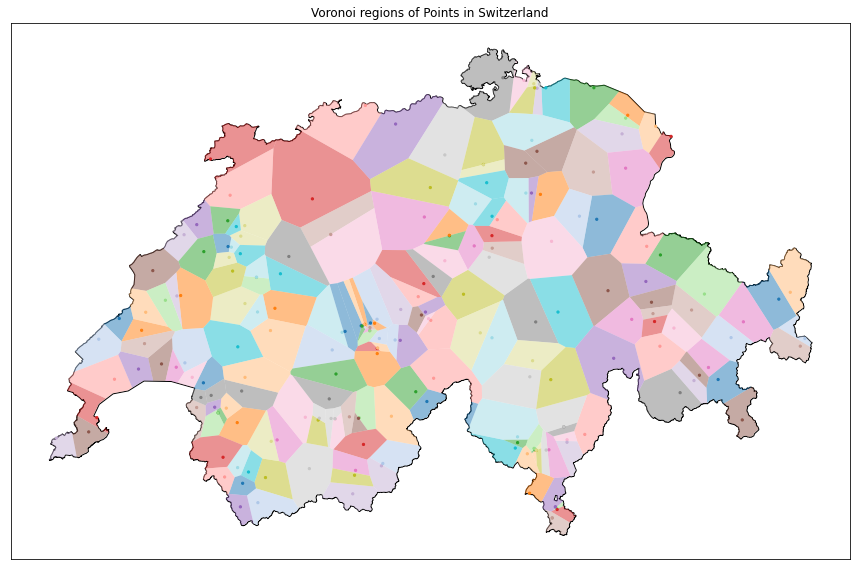

In [20]:
fig, ax = subplot_for_map(figsize=(12, 10))
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments)
ax.set_title('Voronoi regions of Points in Switzerland')
plt.tight_layout()
plt.show()

## A bit better formatted Voronoi plot

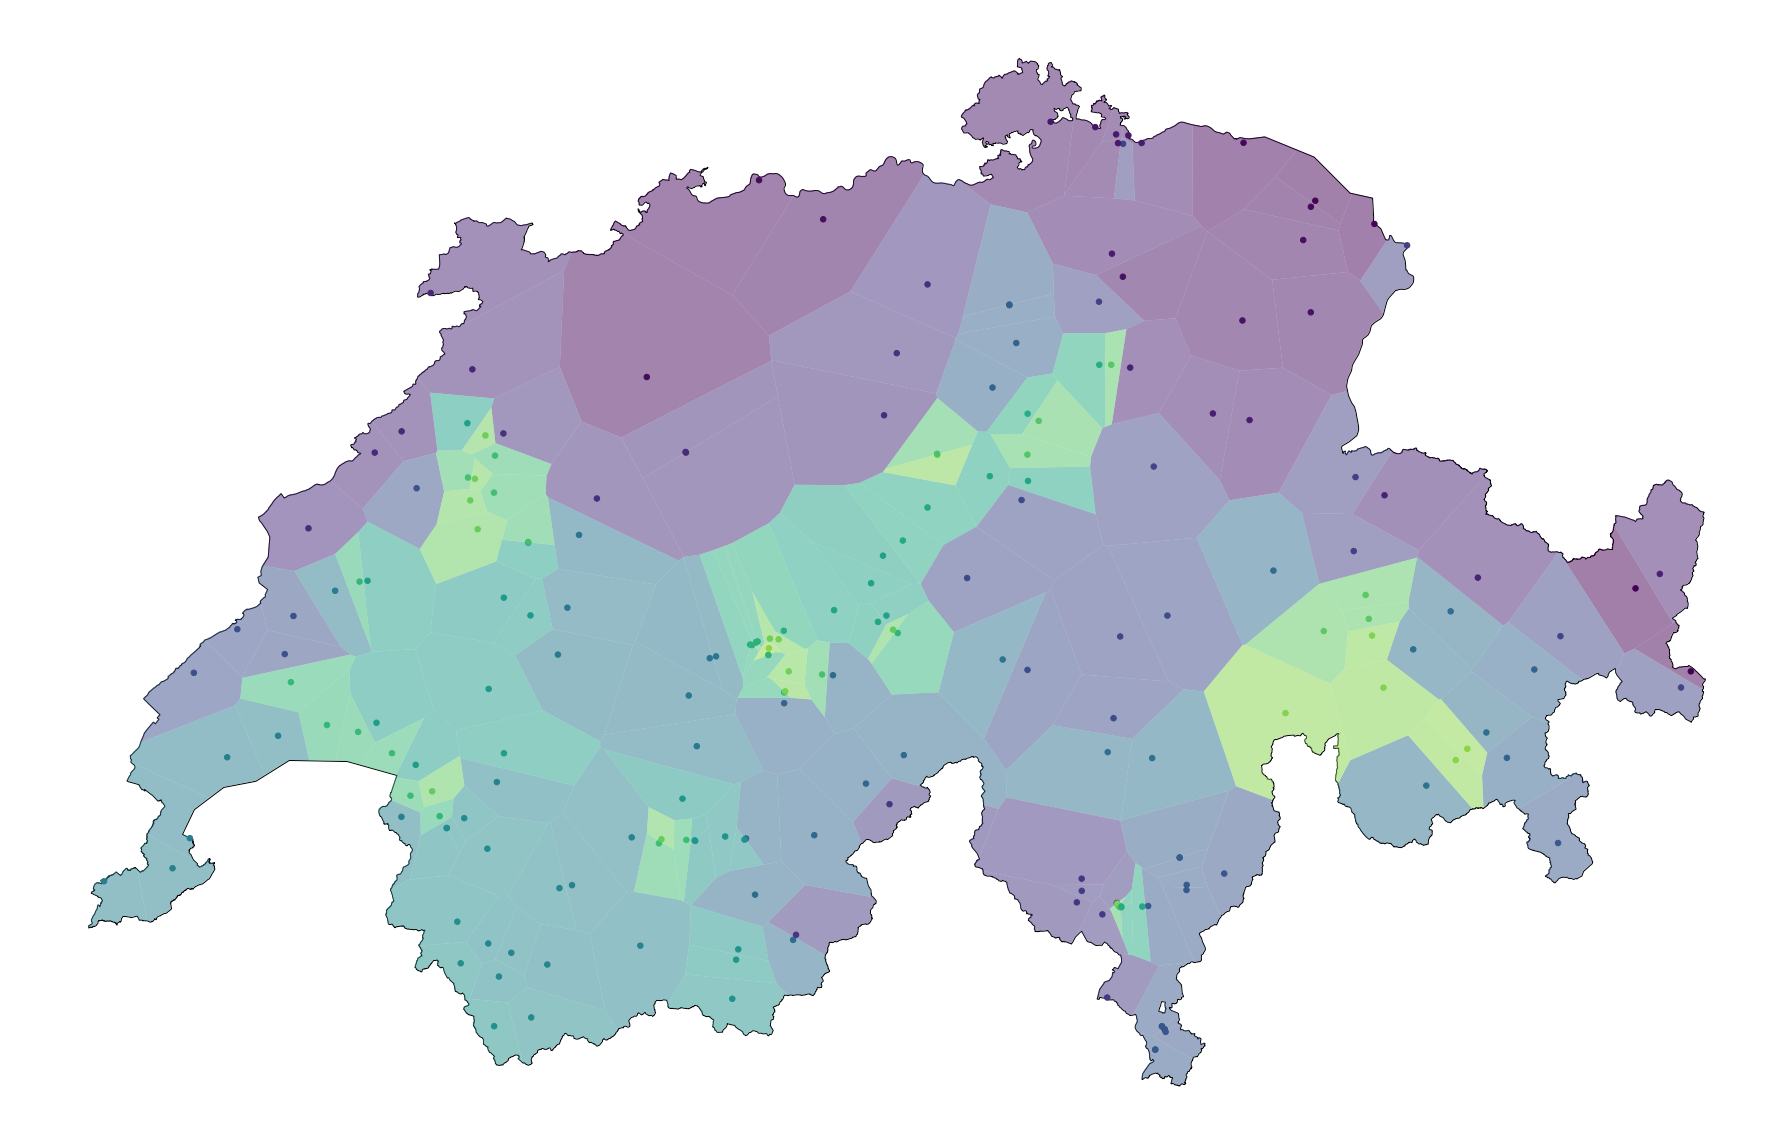

In [27]:
fig, ax = plt.subplots(figsize=(25,16))
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments,
 voronoi_and_points_cmap="viridis",
 points_markersize=30,voronoi_label_fontsize=1)
# ax.set_title("Access to Nature from Cities")
ax.axis("off")
plt.tight_layout()
plt.show()